<div class="alert alert-block alert-danger">
    
### Notes

</div>

###  Regression via gradient descending, $ \ldots $.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels.formula.api import ols

from scipy import stats

In [3]:
plt.close('all')

seed = 123456

np.random.seed(seed)

from numpy.random import default_rng

rng = default_rng(seed)

<hr/>

<div class="alert alert-block alert-info">
Dataset
</div>

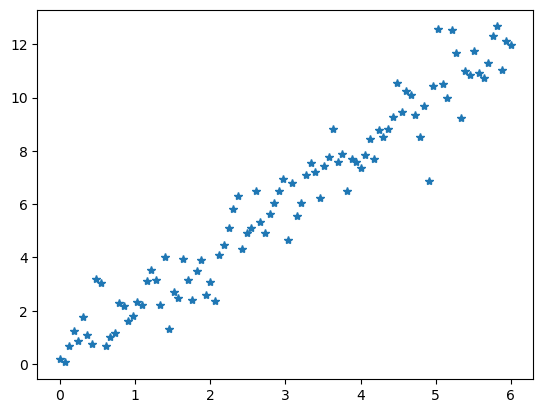

In [4]:
#X = 5.0 * np.random.rand(100)
X = np.linspace(0, 6, 100)
Y = 2 * X + rng.normal(loc=0, scale=1, size=100)

X_augmented = np.column_stack((np.ones(X.shape), X))

plt.plot(X, Y, '*');

---

#### Linear regression via explicit inverse

$ \mathbf{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T Y $

Betas:  [0.21700943 1.97740926]


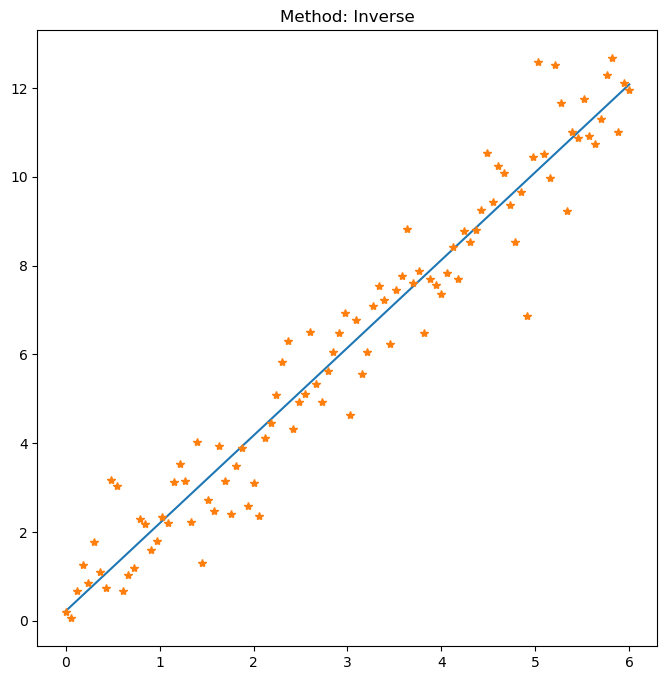

In [5]:
betas = np.linalg.inv(X_augmented.T @ X_augmented) @ X_augmented.T @ Y

print('Betas: ', betas)
plt.figure(figsize=(8,8))
plt.plot(X, betas[0] + betas[1] * X)
plt.title('Method: Inverse')
plt.plot(X, Y, '*');

---

#### Linear regression via least squares

Betas:  0.2769309259075383 1.9574354289903024


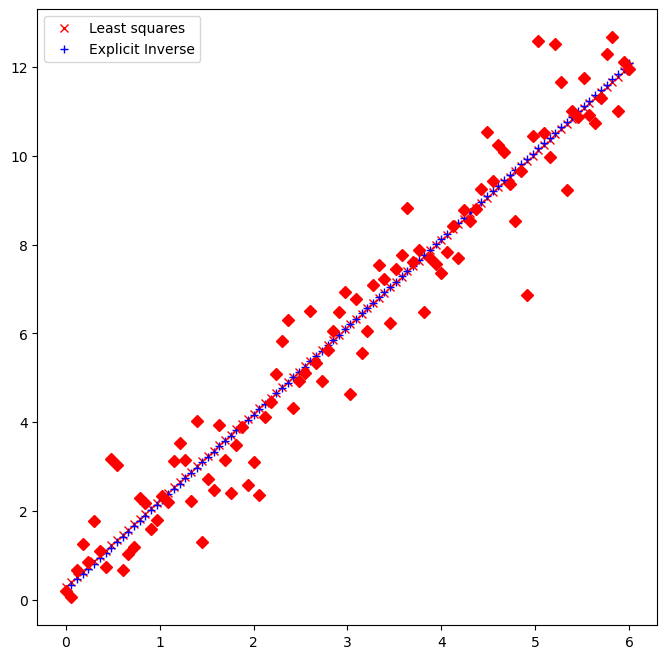

In [6]:
beta_1 = np.cov(X, Y)[0, 1] / np.var(X, ddof=2)
beta_0 = np.mean(Y) - beta_1 * np.mean(X)

print('Betas: ', beta_0, beta_1)
plt.figure(figsize=(8,8))
plt.plot(X, beta_0 + beta_1 * X, 'rx', label='Least squares')
plt.plot(X, betas[0] + betas[1]*X, 'b+', label='Explicit Inverse')
plt.plot(X, Y, 'D', color='r')
plt.legend(loc='best');

---

##### Linear regression via gradient descent

$
\begin{align}
f(\mathbf{\beta}) &= \frac{1}{2} \| \mathbf{X} \mathbf{\beta} - Y \|^2 \\
&= \frac{1}{2} \langle \mathbf{X} \mathbf{\beta} - Y, \mathbf{X} \mathbf{\beta} - Y \rangle \\
&= \frac{1}{2} (\mathbf{X} \mathbf{\beta} - Y)^T (\mathbf{X} \mathbf{\beta} - Y) \\
&= \frac{1}{2} (\mathbf{\beta}^T \mathbf{X}^T - Y^T)(\mathbf{X} \mathbf{\beta} - Y) \\
&= \frac{1}{2} (\mathbf{\beta}^T \mathbf{X}^T \mathbf{X} \mathbf{\beta} - \mathbf{\beta}^T \mathbf{X}^T Y - Y^T \mathbf{X} \mathbf{\beta} + Y^T Y ) \\
\end{align}
$

$
\begin{align}
\frac{\partial{f}}{\partial\mathbf{\beta}} &= \mathbf{\beta}^T \mathbf{X}^T \mathbf{X} - \mathbf{Y}^T \mathbf{X} \\
\mathbf{\beta} &= (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T Y \\
\end{align}
$

Centered differences: $\triangledown_{{f(\mathbf{\beta})}} \approx \langle \frac{f(\mathbf{\beta_0} + \Delta, \mathbf{\beta_1}) - f(\mathbf{\beta_0} - \Delta, \mathbf{\beta_1})}{2\Delta}, \frac{f(\mathbf{\beta_0}, \mathbf{\beta_1} + \Delta) - f(\mathbf{\beta_0}, \mathbf{\beta_1} - \Delta)}{2\Delta} \rangle$ as $\Delta \to 0$

Gradient descent $\mathbf{\beta_{n+1}} := \mathbf{\beta_{n}} - \eta \triangledown f(\mathbf{\beta_{n}})$

In [7]:
def batch_gradient_descent_analytical(beta, learning_rate, precision, max_iterations):

    for i in range(max_iterations):
        next_beta = beta - learning_rate * (beta.T @ X_augmented.T @ X_augmented - Y.T @ X_augmented)
        if np.fabs(next_beta - beta).all() < precision.all():
            print(f'Terminated at iteration: {i}')
            return next_beta
        beta = next_beta
    
    print('Terminated. Max iterations reached.')
    return next_beta


def batch_gradient_descent_numerical(beta, learning_rate, precision, delta_epsilon, max_iterations):

    for i in range(max_iterations):

        fwd_diff_b0 = X_augmented @ (beta + np.array([delta_epsilon, 0])) - Y
        bwd_diff_b0 = X_augmented @ (beta - np.array([delta_epsilon, 0])) - Y
        gradient_vector_b0 = ((fwd_diff_b0.T @ fwd_diff_b0) - (bwd_diff_b0.T @ bwd_diff_b0)) / (2.0 * delta_epsilon)
        
        fwd_diff_b1 = X_augmented @ (beta + np.array([0, delta_epsilon])) - Y
        bwd_diff_b1 = X_augmented @ (beta - np.array([0, delta_epsilon])) - Y
        gradient_vector_b1 = ((fwd_diff_b1.T @ fwd_diff_b1) - (bwd_diff_b1.T @ bwd_diff_b1)) / (2.0 * delta_epsilon)
        
        next_beta = beta - learning_rate * np.array([gradient_vector_b0, gradient_vector_b1])

        if np.fabs(next_beta - beta).all() < precision.all():
            print(f'Terminated at iteration: {i}')
            return next_beta
        beta = next_beta
        
    print('Terminated. Max iterations reached.')
    return next_beta


from random import sample

def mini_batch_stochastic_gradient_descent(beta, learning_rate, precision, delta_epsilon, max_iterations, sample_size=50):
    
    for i in range(max_iterations):
        
        samples = sample(range(len(X_augmented)), sample_size)
        X_, Y_ = X_augmented[samples, :], Y[samples]
        
        fwd_diff_b0 = X_ @ (beta + np.array([delta_epsilon, 0])) - Y_
        bwd_diff_b0 = X_ @ (beta - np.array([delta_epsilon, 0])) - Y_
        gradient_vector_b0 = ((fwd_diff_b0.T @ fwd_diff_b0) - (bwd_diff_b0.T @ bwd_diff_b0)) / (2.0 * delta_epsilon)
        
        fwd_diff_b1 = X_ @ (beta + np.array([0, delta_epsilon])) - Y_
        bwd_diff_b1 = X_ @ (beta - np.array([0, delta_epsilon])) - Y_
        gradient_vector_b1 = ((fwd_diff_b1.T @ fwd_diff_b1) - (bwd_diff_b1.T @ bwd_diff_b1)) / (2.0 * delta_epsilon)
        
        next_beta = beta - learning_rate * np.array([gradient_vector_b0, gradient_vector_b1])

        if np.fabs(next_beta - beta).all() < precision.all():
            print(f'Terminated at iteration: {i}')
            return next_beta
        beta = next_beta
        
    print('Terminated. Max iterations reached.')
    return next_beta

Terminated. Max iterations reached.
Weights (analytical solution):  [0.2176921  1.97723602]
Terminated. Max iterations reached.
Weights (numerical solution):  [0.21701116 1.97740882]
Terminated. Max iterations reached.
Weights (stochastic gradient descent solution):  [0.21575114 1.98480296]


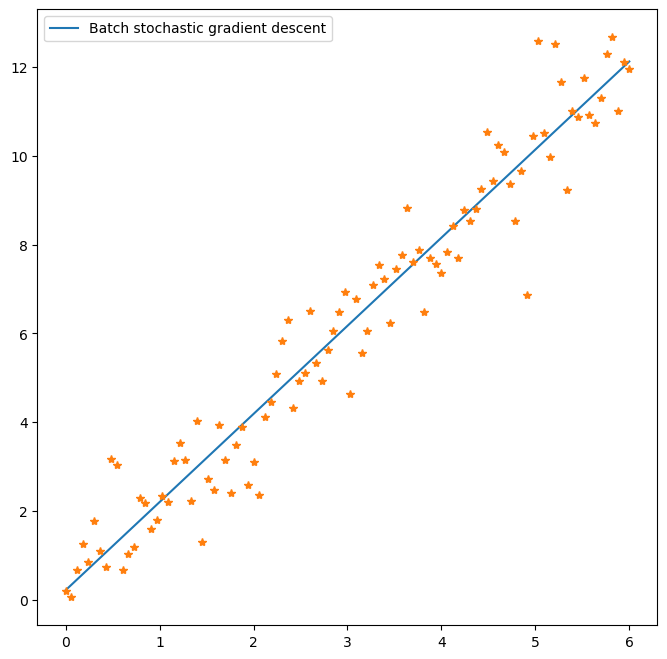

In [8]:
beta_0 = np.zeros(2)
learning_rate = 0.00005
precision_ = np.full(2, 0.000001)
max_iterations = 5000

betas_agd = batch_gradient_descent_analytical(beta_0, learning_rate, precision_, max_iterations)
print('Weights (analytical solution): ', betas_agd)

beta_0 = np.zeros(2)
delta_epsilon = 0.000001
betas_ngd = batch_gradient_descent_numerical(beta_0, learning_rate, precision_, delta_epsilon, max_iterations)
print('Weights (numerical solution): ', betas_ngd)

beta_0 = np.zeros(2)
betas_sgd = mini_batch_stochastic_gradient_descent(beta_0, learning_rate, precision_, delta_epsilon, max_iterations)
print('Weights (stochastic gradient descent solution): ', betas_sgd)

plt.figure(figsize=(8,8))
#plt.plot(X, betas[0] + betas[1] * X, color='b', label='Inverse')
#plt.plot(X, betas_agd[0] + betas_agd[1] * X, color='y', label='Batch gradient descent (analytical)')
#plt.plot(X, betas_ngd[0] + betas_ngd[1] * X, color='r', label='Batch gradient descent (numerical)')
plt.plot(X, betas_sgd[0] + betas_sgd[1] * X, label='Batch stochastic gradient descent')
plt.legend(loc='best')
plt.plot(X, Y, '*');

---

##### Batch Gradient Descent (Non-vectorized version, Row-based)

Let $\mathbf{x}_i \in \mathbb{R}^N$, $\mathbf{y} \in \mathbb{R}^M$

Training dataset $\mathbf{X} \in \mathbb{R}^{(M \times N)}$

Let $\mathbf{x}_i$ denote the $i$ row in the dataset and $y_i \in \mathbb{R}$ the corresponding output.

Let $\mathbf{\beta} := <\beta_0, \beta_1>$

$f(\mathbf{\beta}) = \frac{1}{2} \sum_{i=1}^{M} (\mathbf{\beta}^T \mathbf{x}_i - y_i)^2$

$\nabla f(\mathbf{\beta}) = \sum_{i=1}^{M} (\mathbf{\beta}^T \mathbf{x}_i - y_i) (\mathbf{x}^T_i) $

---

In [9]:
def row_based_gradient_descent_numerical(beta, learning_rate, precision, delta_epsilon, max_iterations):
    
    for i in range(max_iterations):
        for idx in range(len(Y)):
            fwd_diff_b0 = X_augmented[idx] @ (beta + np.array([delta_epsilon, 0])) - Y[idx]
            bwd_diff_b0 = X_augmented[idx] @ (beta - np.array([delta_epsilon, 0])) - Y[idx]
            gradient_vector_b0 = ((fwd_diff_b0.T * fwd_diff_b0) - (bwd_diff_b0.T * bwd_diff_b0)) / (2.0 * delta_epsilon)
            fwd_diff_b1 = X_augmented[idx] @ (beta + np.array([0, delta_epsilon])) - Y[idx]
            bwd_diff_b1 = X_augmented[idx] @ (beta - np.array([0, delta_epsilon])) - Y[idx]
            gradient_vector_b1 = ((fwd_diff_b1.T * fwd_diff_b1) - (bwd_diff_b1.T * bwd_diff_b1)) / (2.0 * delta_epsilon)
            next_beta = beta - learning_rate * np.array([gradient_vector_b0, gradient_vector_b1])
            if np.fabs(next_beta - beta).all() < precision.all():
                print(f'Terminated at iteration: {i}')
                return next_beta
            beta = next_beta
    print('Terminated. Max iterations reached.')
    return next_beta

def row_based_gradient_descent_analytical(beta, learning_rate, precision, max_iterations):

    for i in range(max_iterations):
        for idx in range(len(Y)):
            next_beta = beta - learning_rate * ((beta.T @ X_augmented[idx] - Y[idx]) * X_augmented[idx].T)
            if np.fabs(next_beta - beta).all() < precision.all():
                print(f'Terminated at iteration: {i}')
                return next_beta
            beta = next_beta
    print('Terminated. Max iterations reached.')
    return next_beta

Terminated at iteration: 0
Weights (row-based numerical solution):  [1.92821195e-05 0.00000000e+00]
Terminated at iteration: 0
Weights (row-based analytical solution):  [9.64105977e-06 0.00000000e+00]


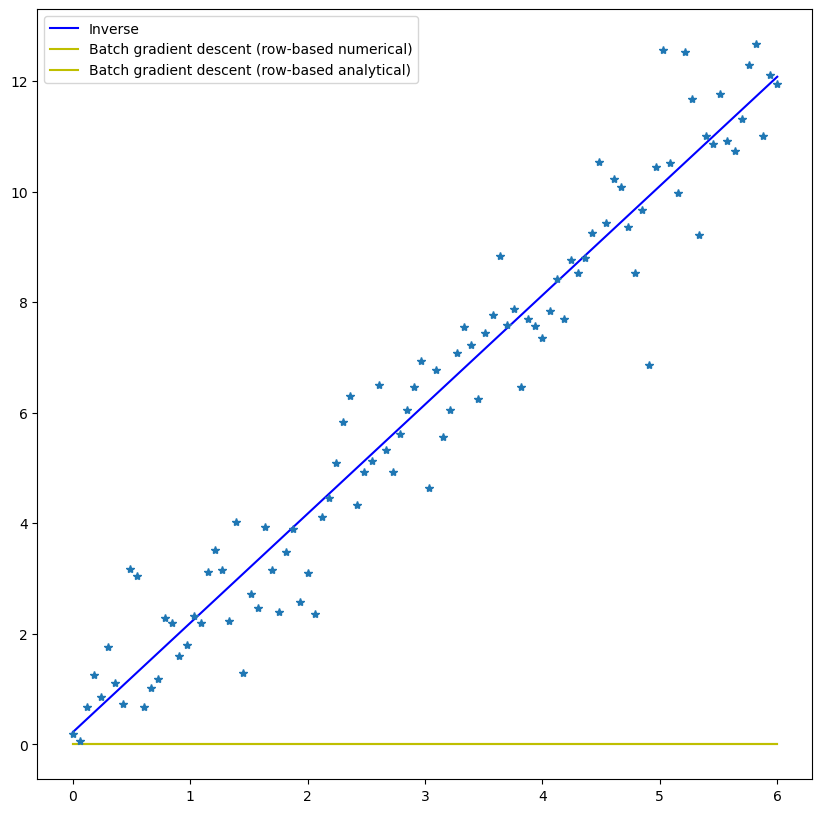

In [10]:
beta_0 = np.zeros(2)
learning_rate = 0.00005
precision_ = np.full(2, 0.000001)
max_iterations = 3000

betas_rbn = row_based_gradient_descent_numerical(beta_0, learning_rate, precision_, delta_epsilon, max_iterations)
print('Weights (row-based numerical solution): ', betas_rbn)

betas_rba = row_based_gradient_descent_analytical(beta_0, learning_rate, precision_, max_iterations)
print('Weights (row-based analytical solution): ', betas_rba)

plt.figure(figsize=(10,10))
plt.plot(X, betas[0] + betas[1] * X, color='b', label='Inverse')
plt.plot(X, betas_rbn[0] + betas_rbn[1] * X, color='y', label='Batch gradient descent (row-based numerical)')
plt.plot(X, betas_rba[0] + betas_rba[1] * X, color='y', label='Batch gradient descent (row-based analytical)')
plt.legend(loc='best')
plt.plot(X, Y, '*');

---

### Regularization

#### Ridge regression (coefficients shrinkage)

$\text{argmin}_{\forall \beta} \{ \mid\mid \mathbf{Y} - \mathbf{X}\mathbf{\beta} \mid\mid_{2} + w\mid\mid \mathbf{\beta} \mid\mid_{2} \}$, $w \ge 0$

---

#### Lasso (least absolute shrinkage and selection operator)

$\text{argmin}_{\forall \beta} \{ \mid\mid \mathbf{Y} - \mathbf{X}\mathbf{\beta} \mid\mid_{2} + w\mid\mid \mathbf{\beta} \mid\mid_{1} \}$, $w \ge 0$

- (constrain with $L_1$ norm instead of Euclidean $L_2$ norm)